In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/galaxy-zoo/'  #change dir to your project folder

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salvatemarty","key":"4482e233721679ee58e3aba7111d1e5c"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge -p /content/gdrive/My\ Drive/galaxy-zoo/

  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 31.7MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 30.3MB/s]
  0% 0.00/520k [00:00<?, ?B/s]
100% 520k/520k [00:00<00:00, 31.1MB/s]
 99% 785M/792M [00:08<00:00, 117MB/s]
100% 792M/792M [00:08<00:00, 99.8MB/s]
 99% 1.00G/1.01G [00:13<00:00, 61.0MB/s]
100% 1.01G/1.01G [00:13<00:00, 80.6MB/s]
  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 40.1MB/s]


In [0]:
!unzip -q /content/gdrive/My\ Drive/galaxy-zoo/images_training_rev1.zip -d /content/gdrive/My\ Drive/galaxy-zoo/

replace /content/gdrive/My Drive/galaxy-zoo/images_training_rev1/100008.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
#!unzip -q /content/gdrive/My\ Drive/galaxy-zoo/training_solutions_rev1.zip -d /content/gdrive/My\ Drive/galaxy-zoo/
!ls /content/gdrive/My\ Drive/galaxy-zoo/

all_ones_benchmark.zip	     images_training_rev1
all_zeros_benchmark.zip      images_training_rev1.zip
central_pixel_benchmark.zip  training_solutions_rev1.csv
images_test_rev1.zip	     training_solutions_rev1.zip


## Exploration of DataSet
#### Import necessary libraries and modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import pickle
import importlib
import sys
import os
import random

In [0]:
# set paths, first workspace path, all the others, relative to work_path
work_path          = "/content/gdrive/My Drive/galaxy-zoo/"
dataSet_path       = work_path+"./"
train_image_path   = dataSet_path+"images_training_rev1/"
train_image_fnames = [ train_image_path+image_name for image_name in os.listdir(train_image_path) ]
train_label_path   = dataSet_path
train_label_fname  = train_label_path+"training_solutions_rev1.csv"

OSError: ignored

In [0]:
# load the labels of galaxies and construct new dataset according to available data
labelDF  = pd.read_csv(train_label_fname)
# create a dataframe from available image names only
galIdSer = pd.Series([ name[:-4] for name in os.listdir(train_image_path) ], name='GalaxyID').to_frame()
# convert int dtype of GalaxyID column on labelDF to string, to be able to match with the previously generate df
labelDF['GalaxyID'] = labelDF['GalaxyID'].apply(lambda x: str(x))
# merge both dfs to create a single classDF for the available data
classDF = labelDF.merge(galIdSer, how='inner', on='GalaxyID')

In [0]:
# Create sub-sample data set frames
smp_galIds       = classDF.sample(10000, random_state=7)['GalaxyID']
smp_image_fnames = [ train_image_path+image_name+".jpg" for image_name in smp_galIds.values]
smp_classDF      = classDF.merge(smp_galIds.to_frame(), how='inner', on='GalaxyID')

Image shape: (424, 424, 3)


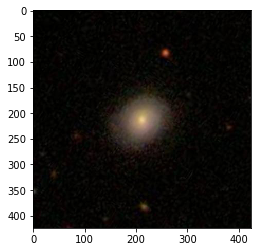

In [0]:
# load one of the images
im0 = image.imread(train_image_fnames[0])
# print it's shape
print('Image shape:', im0.shape)
# show image
plt.imshow(im0)
plt.show()

## Squaring images
Most CNN methods need to be feed with squared images, so we need to ensure that the aspect ratio of all images in the dataSet have an aspect ratio of 1. Else we will need to transform those that do not conform with this condition.

In [0]:
# load all available images into a list as numpy arrays (we will use the sample dataset here)
smp_imgarr = [ image.imread(im_name) for im_name in smp_image_fnames ]

# check if there are images with non-square aspect ratio
wrong_imIdx = list()
for idx, im in enumerate(smp_imgarr):
    im_shape = im.shape
    if im_shape[0]!=im_shape[1]:
        print('Image with index %i is not square, please reshape it, or delete it from dataset'%idx)
        wrong_imIdx.append(idx)

print('Total images with wrong aspect ratio: ', len(wrong_imIdx))

Total images with wrong aspect ratio:  0


Results show that all images seem to have a square aspect ratio. This is important in order to have an optimized model.

Now the next problem is to scale all images to the same shape of pixels. We are going to check first if this is not the case, and, in case we need to rescale any image, we'll do it.

In [0]:
# create a list with each of the images's shape
imshapes = [ im.shape for im in smp_imgarr ]
# get only the unique shapes in the list
print('Different shapes in the images dataSet: ', list(set(imshapes)))

Different shapes in the images dataSet:  [(424, 424, 3)]


Again, we have encountered that all images in the dataset have the same shape. This is again very usefull because the input size for our Neural Network has to be the same for all data in the dataset. Hence, having images with different shapes will result in input with different sizes when Flattening the array of pixel values.

## Mean, Standard Deviation of input data:
Sometimes it’s useful to look at the ‘mean image’ obtained by taking the mean values for each pixel across all training examples. Observing this could give us insight into some underlying structure in the images. 

The standard deviation of all images is shown to the right. Higher variance values show up whiter, so we see that the pictures vary a lot at the boundaries compared to the center.

In [0]:
def get_mean_image(input_images):
    import numpy as np
    import os
    from matplotlib import image
    
    if isinstance(input_images, str):
        input_images_list = [ image.imread(name) for name  in os.listdir(input_images) ]
    elif isinstance(input_images, list):
        im0 = input_images[0]
        if isinstance(im0, str):
            input_images_list = [image.imread(name) for name in input_images ] 
        elif isinstance(im0, np.ndarray):
            input_images_list = input_images
        else:
            print("Input type not recognized.")
            return None
    else:
        print("Input type not recognized.")
        return None
    
    
    # Alternative method using numpy mean function
    arr = np.array(np.mean(input_images_list, axis=(0)), dtype=np.uint8)
    
    return arr

def get_std_image(input_images):
    import numpy as np
    import os
    from matplotlib import image
    
    if isinstance(input_images, str):
        input_images_list = [ image.imread(name) for name  in os.listdir(input_images) ]
    elif isinstance(input_images, list):
        im0 = input_images[0]
        if isinstance(im0, str):
            input_images_list = [image.imread(name) for name in input_images ] 
        elif isinstance(im0, np.ndarray):
            input_images_list = input_images
        else:
            print("Input type not recognized.")
            return None
    else:
        print("Input type not recognized.")
        return None
    
    
    # Alternative method using numpy mean function
    arr = np.array(np.std(input_images_list, axis=(0)), dtype=np.uint8)
    
    return arr
    

In [0]:
av_arr = get_mean_image2(smp_imgarr)
plt.imshow(av_arr)
plt.show()

NameError: ignored

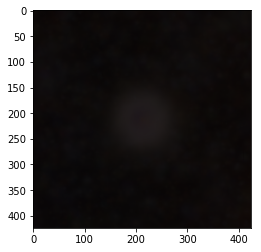

In [0]:
std_arr = get_std_image(smp_imgarr)
plt.imshow(std_arr)
plt.show()

## Building our Convolutional Neural Network
We will begin to build our first attempt to classify the galaxies through a trained CNN (Convolutional Neural Network). We will start using keras API library, which is the most straighforward library, and as it runs over tensorFlow, it is capable of using the CUDA capabilities of the procesor.

In [0]:
#Importing the keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
# set metaparameters
batch_size  = 128
epochs      = 10
num_classes = num_classes = len(smp_classDF.columns)-1

In [0]:
# initialize the CNN
model = Sequential()

# Step 1 - Convolution
model.add(Convolution2D(32, 
                        kernel_size=(7,7), 
                        strides=(2,2),
                        activation='relu',
                        input_shape=(424, 424, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))
model.add(Convolution2D(64, 
                        (5,5), 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100, 
                activation='relu'))
model.add(Dense(num_classes, 
                activation='softmax'))

W0625 16:16:37.240138 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 16:16:37.278412 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 16:16:37.282305 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 16:16:37.304345 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
# compile model
model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

W0625 16:16:40.602845 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 16:16:40.614230 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
from sklearn.model_selection import train_test_split
yDF = smp_classDF.drop('GalaxyID', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(smp_imgarr, yDF, test_size=0.2)

In [0]:
from keras.callbacks import Callback
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

W0625 16:17:15.594486 140050485233536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0625 16:17:15.669144 140050485233536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 8000 samples, validate on 2000 samples
Epoch 1/10


In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 69.88455444335938
Test accuracy: 0.59
